# Helper Functions

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

False


In [2]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set memory growth to avoid TensorFlow from consuming all GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  0


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9278352165070892044
xla_global_id: -1
]


In [2]:
def collect_stock_history(ticker,period='1y',interval='1d'):

    stock = yf.Ticker(ticker)
    history = stock.history(period=period,interval=interval)

    return history

In [5]:
global portfolio

In [6]:
def get_history():
    for i in range(len(portfolio)):
        portfolio[i]['history'] = collect_stock_history(portfolio[i]['ticker'],period='20y',interval='1d')

In [7]:
def add_technical_indicators(df):
    # momentum
    df['MOM'] = df['Close'].diff(5)
    # RSI (14-day)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    # volume indicators
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    return df

# model features
def prepare_data(df):
    features = ['Open', 'High', 'Low', 'Close', 'Volume',
                'MOM', 'RSI', 'MA5', 'MA20',
                'Volume_MA5', 'Volume_MA20']
    df = add_technical_indicators(df)
    df = df.dropna()
    # normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[features])

    return df_scaled, scaler, features

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 3])  # 3 is close price index
    return np.array(X), np.array(y)


In [8]:
def train_models():
  for i in range(len(portfolio)):
      print('Processing ',portfolio[i]['ticker'])
      df = portfolio[i]['history']
      df_scaled, scaler, features = prepare_data(df)
      seq_length = 50
      X, y = create_sequences(df_scaled, seq_length)
      train_size = int(len(X) * 0.8)
      X_train, y_train = X[:train_size], y[:train_size]
      X_test, y_test = X[train_size:], y[train_size:]

      portfolio[i]['X_train'] = X_train
      portfolio[i]['y_train'] = y_train
      portfolio[i]['X_test'] = X_test
      portfolio[i]['y_test'] = y_test

      model = Sequential([
          LSTM(100, return_sequences=True, input_shape=(seq_length, len(features))),
          Dropout(0.2),
          LSTM(100, return_sequences=True),
          Dropout(0.2),
          LSTM(50, return_sequences=False),
          Dropout(0.2),
          Dense(25),
          Dense(1)
      ])

      initial_learning_rate = 0.001
      decay_steps = 10000
      decay_rate = 0.9
      learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate, decay_steps, decay_rate
      )
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
      model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=10,
          restore_best_weights=True
      )
      history = model.fit(
          X_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping]
      )
      portfolio[i]['model'] = model
      portfolio[i]['scaler'] = scaler
      portfolio[i]['features'] = features

In [9]:
def predict_prices():
    for i in range(len(portfolio)):
        model = portfolio[i]['model']
        scaler = portfolio[i]['scaler']
        features = portfolio[i]['features']

        X_test = portfolio[i]['X_test']
        y_test = portfolio[i]['y_test']

        print(len(y_test))

        predictions = model.predict(X_test)

        # create template array filled with zeros and put pred vals in the close price column (idx 3)
        pred_template = np.zeros((len(predictions), len(features)))
        pred_template[:, 3] = predictions.flatten()

        # convert preds back to original scale
        predictions = scaler.inverse_transform(pred_template)[:, 3]

        # actual values transformation
        actual_template = np.zeros((len(y_test), len(features)))
        actual_template[:, 3] = y_test
        actual_prices = scaler.inverse_transform(actual_template)[:, 3]

        plt.figure(figsize=(12,6))
        plt.plot(actual_prices, label="Actual Prices", color="blue")
        plt.plot(predictions, label="Predicted Prices", color="red")
        plt.title(f"Stock Price Prediction for {portfolio[i]['ticker']}")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

        mae = mean_absolute_error(actual_prices, predictions)
        rmse = np.sqrt(mean_squared_error(actual_prices, predictions))

        print(f"Mean Absolute Error (MAE) in dollars per prediction: {mae:.4f}")
        print(f"Root Mean Squared Error (RMSE) in dollars per prediction: {rmse:.4f}")

        portfolio[i]['predictions'] = predictions
        portfolio[i]['actual_prices'] = actual_prices


# Trading

In [10]:
portfolio = [{'ticker':'AAPL'},
              {'ticker':'NVDA'},
             {'ticker':'COKE'}]

Processing  AAPL
Epoch 1/50


d:\USC\DSCI560 - Shubham\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0019 - mae: 0.0267 - val_loss: 0.0035 - val_mae: 0.0478
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 3.1685e-04 - mae: 0.0111 - val_loss: 0.0013 - val_mae: 0.0290
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.7906e-04 - mae: 0.0105 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.2925e-04 - mae: 0.0100 - val_loss: 0.0038 - val_mae: 0.0515
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.9786e-04 - mae: 0.0089 - val_loss: 0.0037 - val_mae: 0.0563
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 3.5599e-04 - mae: 0.0120 - val_loss: 0.0017 - val_mae: 0.0305
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.5365e-04 - mae: 0.0080 - val_loss: 0.0020 - val_mae: 0.0396
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 3.3695e-04 - mae: 0.0109 - val_loss: 0.0023 - val_mae: 0.0370
Epoch 9/50
125/125 ━━━━━━━━━━━━

d:\USC\DSCI560 - Shubham\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0028 - mae: 0.0314 - val_loss: 0.0157 - val_mae: 0.0722
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 3.6917e-05 - mae: 0.0046 - val_loss: 0.0135 - val_mae: 0.0659
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.7971e-05 - mae: 0.0040 - val_loss: 0.0180 - val_mae: 0.0775
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.0639e-05 - mae: 0.0035 - val_loss: 0.0174 - val_mae: 0.0736
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.8721e-05 - mae: 0.0033 - val_loss: 0.0164 - val_mae: 0.0704
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.7381e-05 - mae: 0.0031 - val_loss: 0.0224 - val_mae: 0.0852
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.7005e-05 - mae: 0.0031 - val_loss: 0.0194 - val_mae: 0.0763
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.3043e-05 - mae: 0.0027 - val_loss: 0.0252 - val_mae: 0.0906
Epoch 9/50
125/125 ━━━━━━━━━━━━

d:\USC\DSCI560 - Shubham\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0016 - mae: 0.0240 - val_loss: 0.0063 - val_mae: 0.0486
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.1238e-04 - mae: 0.0075 - val_loss: 0.0094 - val_mae: 0.0630
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 9.6176e-05 - mae: 0.0068 - val_loss: 0.0072 - val_mae: 0.0530
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.4543e-05 - mae: 0.0062 - val_loss: 0.0077 - val_mae: 0.0561
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.7318e-05 - mae: 0.0057 - val_loss: 0.0114 - val_mae: 0.0806
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 8.2290e-05 - mae: 0.0063 - val_loss: 0.0060 - val_mae: 0.0494
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 7.8641e-05 - mae: 0.0064 - val_loss: 0.0076 - val_mae: 0.0616
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.5904e-05 - mae: 0.0057 - val_loss: 0.0041 - val_mae: 0.0392
Epoch 9/50
125/125 ━━━━━━━━━━━━

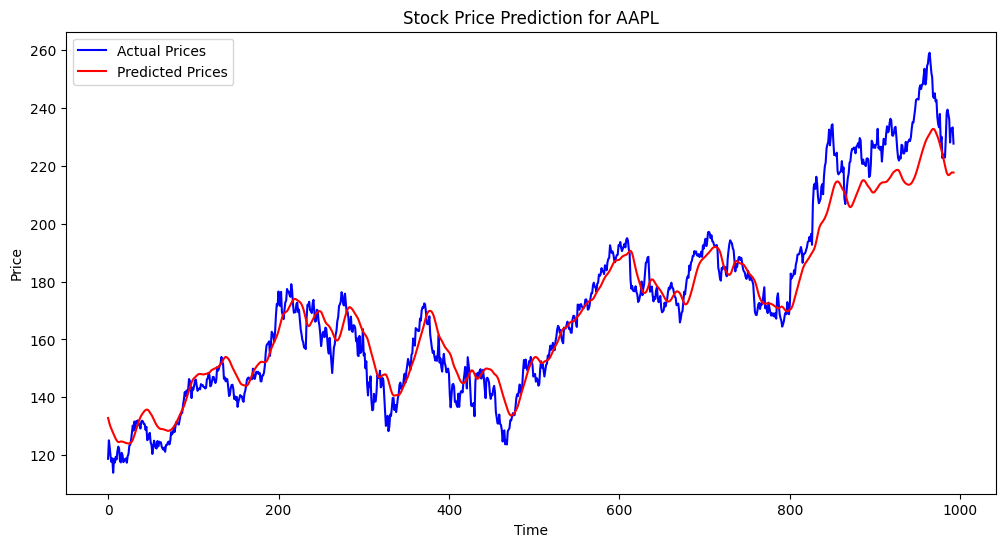

Mean Absolute Error (MAE) in dollars per prediction: 6.5742
Root Mean Squared Error (RMSE) in dollars per prediction: 8.6188
993
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


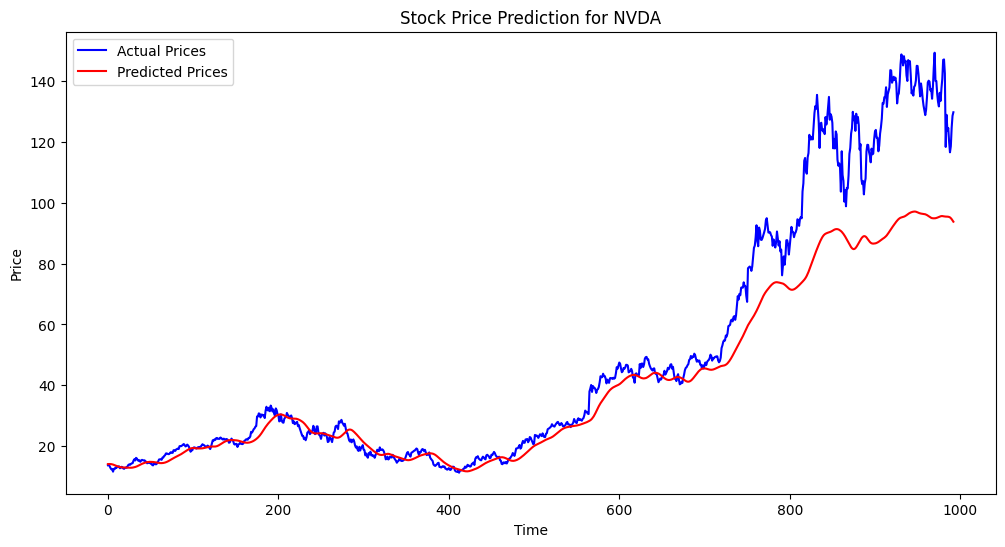

Mean Absolute Error (MAE) in dollars per prediction: 9.8426
Root Mean Squared Error (RMSE) in dollars per prediction: 17.3192
993
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


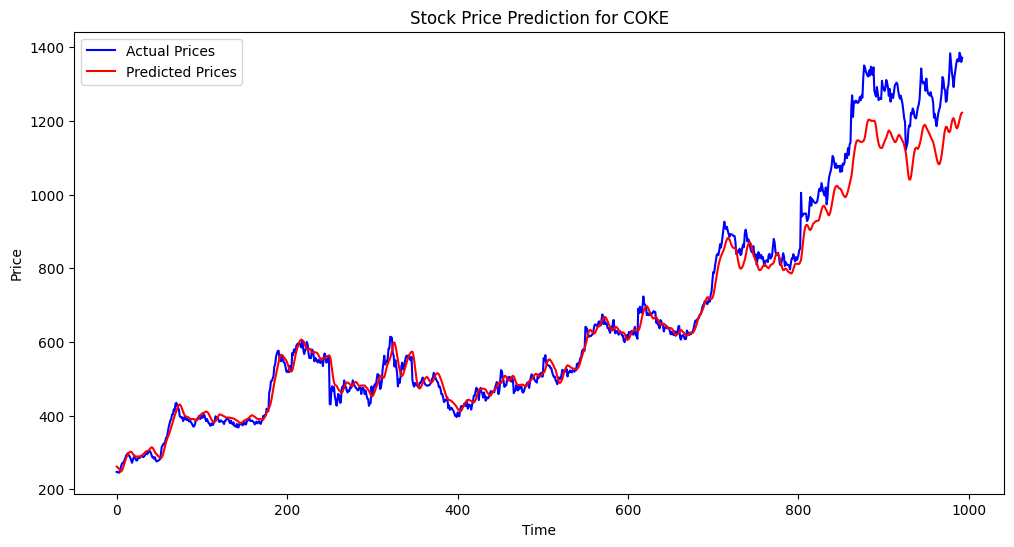

Mean Absolute Error (MAE) in dollars per prediction: 34.7824
Root Mean Squared Error (RMSE) in dollars per prediction: 55.2383


In [11]:
get_history()
train_models()
predict_prices()

In [12]:
# portfolio parameters
total_cash = 10000
threshold = 0.005
min_profit = 0.001

In [13]:
# mock trading simulation
portfolio_value = 0
shares_held = {stock['ticker']: 0 for stock in portfolio}
transactions = []
portfolio_value_history = []
cash = total_cash
for i in range(min([len(stock['actual_prices']) for stock in portfolio]) - 1):
    print(f"\n--- Day {i} ---")

    # update portfolio value before trading
    portfolio_value = cash
    for stock in portfolio:
        ticker = stock['ticker']
        current_price = stock['actual_prices'][i]
        portfolio_value += shares_held[ticker] * current_price

    portfolio_value_history.append(portfolio_value)

    for stock in portfolio:
        ticker = stock['ticker']
        actual_prices = stock['actual_prices']
        predicted_prices = stock['predictions']

        current_price = actual_prices[i]
        predicted_next_price = predicted_prices[i+1]

        print(f"\n{ticker}: Current Price: {current_price:.2f}, Predicted Next: {predicted_next_price:.2f}")
        print(f"    Shares Held: {shares_held[ticker]}, Cash Available: {cash:.2f}")

        # BUY condition: predicted price increase
        if (predicted_next_price > current_price * (1 + threshold) and cash >= current_price):
            shares_to_buy = int((cash * 0.8) // current_price)
            if shares_to_buy > 0:
                cash -= shares_to_buy * current_price
                shares_held[ticker] += shares_to_buy
                transactions.append(f"BUY {shares_to_buy} shares of {ticker} at {current_price:.2f}")
                print(f"BUY {shares_to_buy} shares of {ticker} at {current_price:.2f}")

        # SELL condition: predicted price drop and profit > min_profit
        elif (predicted_next_price < current_price * (1 - threshold) and
              (current_price - predicted_next_price) / current_price > min_profit and shares_held[ticker] > 0):
            shares_to_sell = shares_held[ticker]
            cash += shares_to_sell * current_price
            shares_held[ticker] -= shares_to_sell
            transactions.append(f"SELL {shares_to_sell} shares of {ticker} at {current_price:.2f}")
            print(f"SELL {shares_to_sell} shares of {ticker} at {current_price:.2f}")

# get final portfolio value
final_portfolio_value = cash
for stock in portfolio:
    ticker = stock['ticker']
    final_price = stock['actual_prices'][-1]
    final_portfolio_value += shares_held[ticker] * final_price

print("\n--- Final Trade Summary ---")
print(f"Initial Investment: ${total_cash:,.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Total Return: {((final_portfolio_value - total_cash) / total_cash) * 100:.2f}%")

daily_returns = np.diff(portfolio_value_history) / portfolio_value_history[:-1]
annualized_return = np.mean(daily_returns) * 252
print(f"\nAnnualized Return: {annualized_return:.2%}")
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Total Trades Executed: {len(transactions)}")



--- Day 0 ---

AAPL: Current Price: 118.75, Predicted Next: 131.66
    Shares Held: 0, Cash Available: 10000.00
BUY 67 shares of AAPL at 118.75

NVDA: Current Price: 13.68, Predicted Next: 14.08
    Shares Held: 0, Cash Available: 2043.62
BUY 119 shares of NVDA at 13.68

COKE: Current Price: 247.23, Predicted Next: 260.00
    Shares Held: 0, Cash Available: 415.73
BUY 1 shares of COKE at 247.23

--- Day 1 ---

AAPL: Current Price: 125.15, Predicted Next: 130.60
    Shares Held: 67, Cash Available: 168.50
BUY 1 shares of AAPL at 125.15

NVDA: Current Price: 13.81, Predicted Next: 14.08
    Shares Held: 119, Cash Available: 43.36
BUY 2 shares of NVDA at 13.81

COKE: Current Price: 247.46, Predicted Next: 257.72
    Shares Held: 1, Cash Available: 15.74

--- Day 2 ---

AAPL: Current Price: 122.53, Predicted Next: 129.74
    Shares Held: 68, Cash Available: 15.74

NVDA: Current Price: 13.37, Predicted Next: 14.07
    Shares Held: 121, Cash Available: 15.74

COKE: Current Price: 245.05, Pr

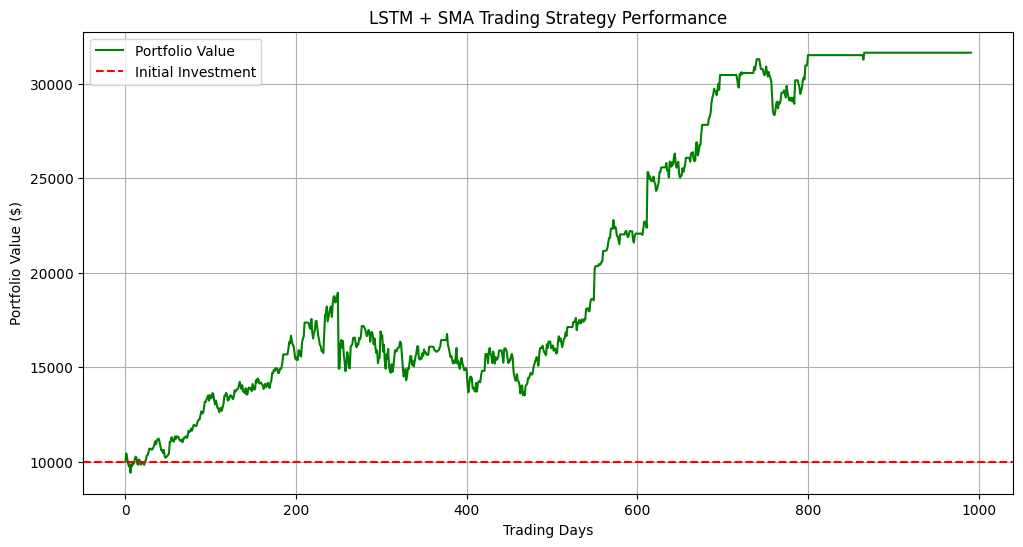

In [14]:
#Mock Trading Results Plot
plt.figure(figsize=(12,6))
plt.plot(portfolio_value_history, label="Portfolio Value", color="green")
plt.axhline(y=total_cash, color='r', linestyle='--', label='Initial Investment')
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")
plt.title("LSTM + SMA Trading Strategy Performance")
plt.legend()
plt.grid(True)
plt.show()
